In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

import torchvision
import torchvision.transforms as transforms

from torchvision import models
from torchvision import utils

from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import cv2
import os

## 1. Реализация классических алгоритмов

Сюда для пример сложила изображения из private датасет, чтобы оценить качество работы алгоритмов,
а затем проверить их работу на всем публичном датасете

In [3]:
# Путь к папке с изображениями
train_path = "/Users/alinamiller/Desktop/AI Talent Hub/CV/data/train_1"
test_path = "/Users/alinamiller/Desktop/AI Talent Hub/CV/data/test_1"

In [5]:
# Список всех изображений
train = []
test = []
train_filenames = []
test_filenames = [] 
for filename in os.listdir(train_path):
    if filename.endswith(".jpg"): 
        img_path = os.path.join(train_path, filename)
        image = cv2.imread(img_path) 
        
        if image is not None:
            train.append(image)
            train_filenames.append(filename) 

for filename in os.listdir(test_path):
    if filename.endswith(".jpg"):  
        img_path = os.path.join(test_path, filename)
        image = cv2.imread(img_path) 
        
        if image is not None:
            test.append(image)
            test_filenames.append(filename) 

In [7]:
# Посмотрим на размеры изображений в папке train
for i in os.listdir(train_path):
    img_path = os.path.join(train_path, i) 
    if img_path.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image = cv2.imread(img_path)  
        print(image.shape, i)

(1875, 3000, 3) 000018.jpg
(780, 695, 3) 000232.jpg
(864, 1536, 3) 000008.jpg
(834, 736, 3) 000009.jpg
(720, 1280, 3) 000220.jpg
(834, 736, 3) 000043.jpg
(1080, 1440, 3) 000262.jpg
(552, 736, 3) 000013.jpg
(1080, 1920, 3) 000012.jpg
(2041, 3629, 3) 000006.jpg
(1990, 3000, 3) 000010.jpg
(714, 1000, 3) 000004.jpg
(750, 1200, 3) 000011.jpg
(1280, 1920, 3) 000000.jpg
(683, 1024, 3) 000014.jpg
(429, 1000, 3) 000002.jpg
(1125, 2000, 3) 000016.jpg
(736, 736, 3) 000017.jpg
(1440, 2560, 3) 000003.jpg


In [9]:
# Посмотрим на размеры изображений в папке test
for i in os.listdir(test_path):
    img_path = os.path.join(test_path, i)  
    if img_path.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        image = cv2.imread(img_path)  
        print(image.shape, i)

(720, 1280, 3) 000233.jpg
(1080, 1440, 3) 000221.jpg
(640, 1024, 3) 000252.jpg
(576, 1024, 3) 000309.jpg
(780, 695, 3) 000266.jpg
(780, 695, 3) 000313.jpg
(628, 1200, 3) 000248.jpg
(540, 720, 3) 000275.jpg
(800, 1200, 3) 000329.jpg
(628, 1200, 3) 000302.jpg
(780, 695, 3) 000238.jpg
(1125, 2000, 3) 000015.jpg


Изображения разных размеров, при обработке нужно будет этот учесть

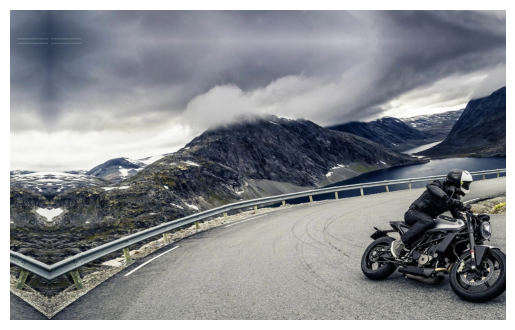

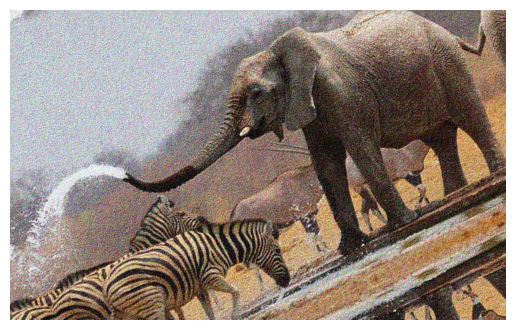

In [12]:
train_image = cv2.cvtColor(train[0], cv2.COLOR_BGR2RGB)
test_image = cv2.cvtColor(test[2], cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(train_image)
plt.axis("off")  
plt.show()

# Отображаем изображение
plt.imshow(test_image)
plt.axis("off") 
plt.show()

In [14]:
# Проверка загрузки
print(f"Загружено {len(train)} изображений.")
print(f"Загружено {len(test)} изображений.")

Загружено 19 изображений.
Загружено 12 изображений.


Попробуем дефолтным сифтом получить декстрипторы

In [17]:
# Инициализируем SIFT
sift = cv2.SIFT_create(nfeatures=300, nOctaveLayers=4, contrastThreshold=0.08, edgeThreshold=10)

Вычислим декрипторы

In [20]:
# Функция вычисления дескрипторов
def compute_sift_descriptors(images):
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Перевод в ЧБ
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        descriptors_list.append(descriptors) 
    return descriptors_list

# Вычисляем дескрипторы
train_descriptors = compute_sift_descriptors(train)
test_descriptors = compute_sift_descriptors(test)
print("Дескрипторы вычислены!")

Дескрипторы вычислены!


Отобразим полученные ключевые точки на маленькой выборке изображений

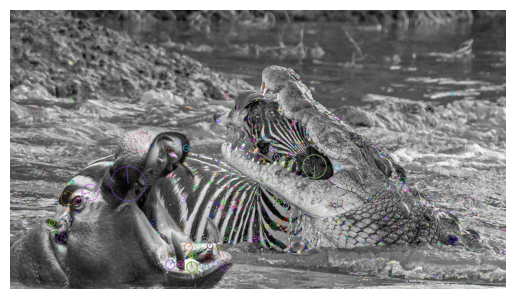

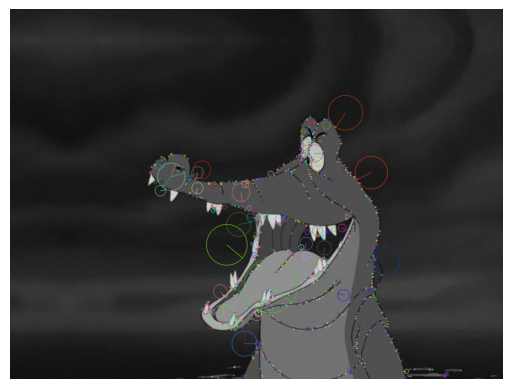

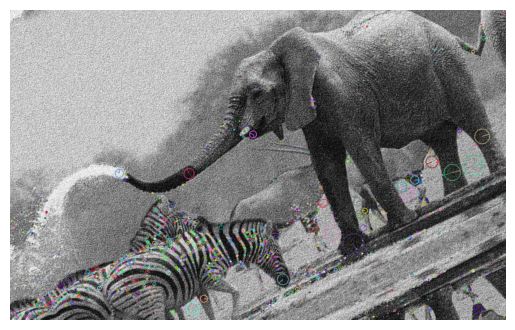

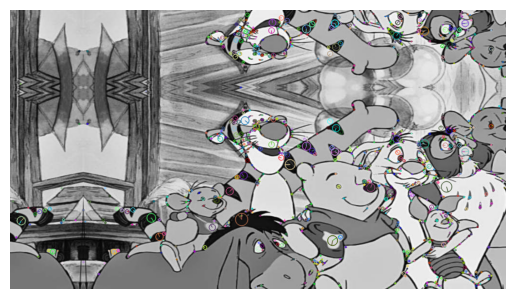

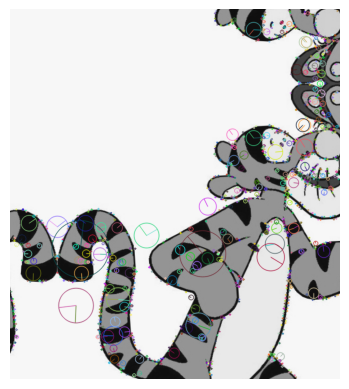

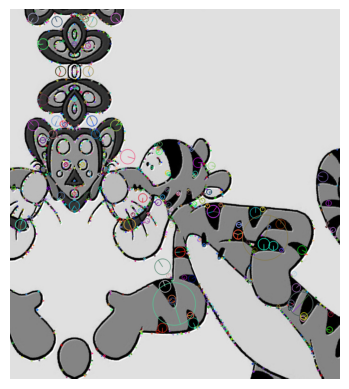

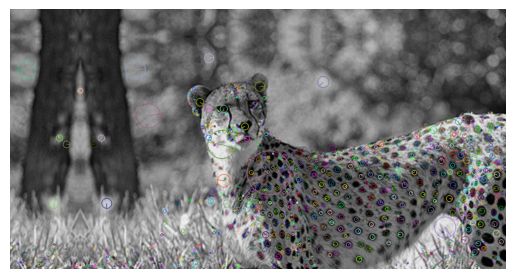

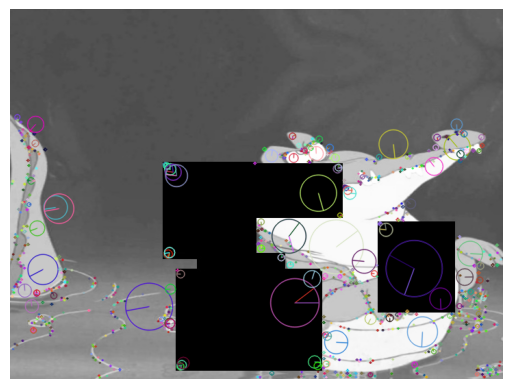

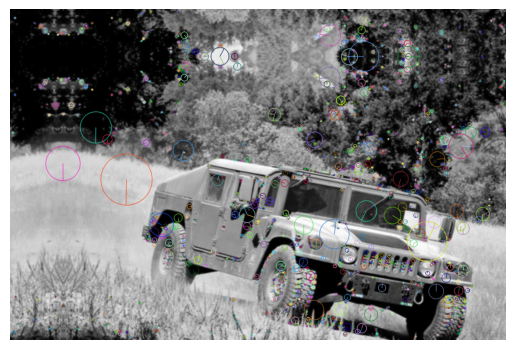

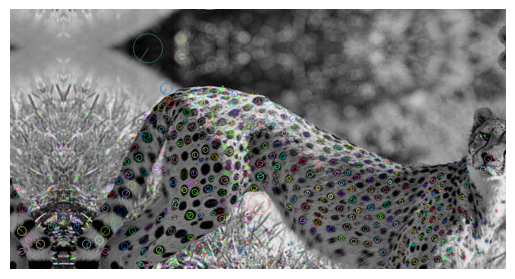

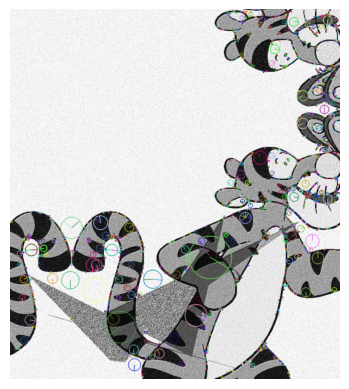

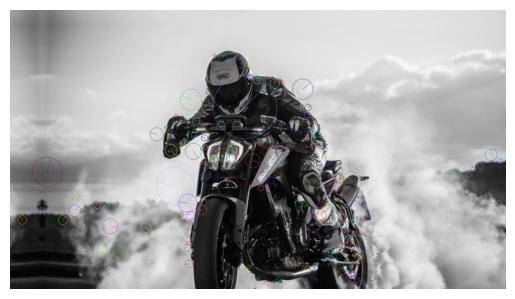

In [21]:
for i in os.listdir(test_path):
    img_path = os.path.join(test_path, i)
    if img_path.endswith(".jpg"): 
        image = cv2.imread(img_path)
        gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        # Применяем SIFT 
        sift = cv2.SIFT_create(nfeatures=1300, nOctaveLayers=4, contrastThreshold=0.03)
        kp = sift.detect(gray, None)
        
        # Разметил ключевые точки
        img=cv2.drawKeypoints(gray ,
            kp ,
            image ,
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        cv2.imwrite('image-with-keypoints.jpg', img)
        plt.imshow(img)
        plt.axis("off")  
        plt.show()

Для того, чтобы сравнивать изоражениям между собой по дескрипторам нам нужен алгоритм сравнения.
Dозьмем для начала Brute-Force Matcher

Попробуем для тестовых изображений найти похожие на основе дескрипторов SIFT-а с помощью BF Matcher

In [35]:
# Функция для поиска похожих изображений
def find_similar_images(test_descriptors, test_filenames, train_descriptors, train_filenames):
    bf = cv2.BFMatcher(cv2.NORM_L2) 
    results = []

    for i, test_desc in enumerate(test_descriptors):
        best_match_filename = None
        best_match_count = 0

        for j, train_desc in enumerate(train_descriptors):
            if test_desc is not None and train_desc is not None:
                matches = bf.match(test_desc, train_desc)
                if len(matches) > best_match_count:
                    best_match_count = len(matches)
                    best_match_filename = train_filenames[j]

        results.append((test_filenames[i], best_match_filename))

    return results

In [37]:
similar_images = find_similar_images(test_descriptors, test_filenames, train_descriptors, train_filenames)

for test_file, train_file in similar_images:
    if train_file:
        print(f"Тестовое изображение {test_file} похоже на изображение {train_file} из тренировочного датасета")
    else:
        print(f"Для тестового изображения {test_file} не найдено совпадений")


Тестовое изображение 000233.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000221.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000252.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000309.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000266.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000313.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000248.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000275.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000329.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000302.jpg похоже на изображение 000018.jpg из тренировочного датасета
Тестовое изображение 000238.jpg похоже на изображение 000018.jpg из тренировочно

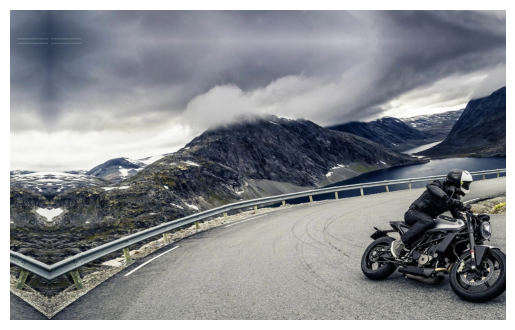

In [54]:
# Посмотрим, что это за изображение
image = cv2.cvtColor(cv2.imread(train_path+'/000018.jpg'), cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(image)
plt.axis("off")
plt.show()


Видно, что пока что для всех изображений найдено одно похоже, что не очень похоже на правду, так как в датасете было много разных изображений.

### 1.1. Доработка SIFT-а 

Приведем все к одному размеру, добавим в алгоритм аугментации тестовых изображений, посчитаем дексриптоы и поищем похожие

In [59]:

# Функция для изменения размера изображений
def resize_images(images, size=(512, 512)):
    return [cv2.resize(img, size) for img in images]

# Аугментации для тестовых изображений
def generate_augmented_versions(image):
    versions = []
    versions.append(image)  # оригинал
    versions.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
    versions.append(cv2.rotate(image, cv2.ROTATE_180))
    versions.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    versions.append(cv2.flip(image, 1))  # горизонтальное отражение
    versions.append(cv2.bitwise_not(image))  # инверсия цвета
    return versions

# Вычисление SIFT дескрипторов
def compute_sift_descriptors(images):
    sift = cv2.SIFT_create(nOctaveLayers=4, contrastThreshold=0.04)
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        descriptors_list.append(descriptors)
    return descriptors_list

# Поиск наиболее похожего изображения
def find_similar_images(test_images, test_filenames, train_descriptors, train_filenames, threshold=5):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    similar_images = {}

    for i, original_img in enumerate(test_images):
        test_file = test_filenames[i]
        best_match_filename = None
        best_match_score = 0

        augmented_images = generate_augmented_versions(original_img)
        augmented_descriptors = compute_sift_descriptors(augmented_images)

        # Сравниваем все версии одного тест-изображения с обучающими
        for test_desc in augmented_descriptors:
            if test_desc is None:
                continue
            for j, train_desc in enumerate(train_descriptors):
                if train_desc is not None:
                    matches = bf.knnMatch(test_desc, train_desc, k=2)

                    # Ratio Test
                    good_matches = []
                    for m, n in matches:
                        if m.distance < 0.75 * n.distance:
                            good_matches.append(m)

                    if len(good_matches) > best_match_score and len(good_matches) >= threshold:
                        best_match_score = len(good_matches)
                        best_match_filename = train_filenames[j]

        if best_match_filename:
            similar_images[test_file] = best_match_filename

    return similar_images

In [61]:
# Загружаем изображения из папки train
for filename in os.listdir(train_path):
    if filename.endswith(".jpg"):
        img_path = os.path.join(train_path, filename)
        image = cv2.imread(img_path)
        if image is not None:
            train.append(image)
            train_filenames.append(filename)

# Загружаем изображения из папки test
for filename in os.listdir(test_path):
    if filename.endswith(".jpg"):
        img_path = os.path.join(test_path, filename)
        image = cv2.imread(img_path)
        if image is not None:
            test.append(image)
            test_filenames.append(filename)

In [63]:
# Предобработка изображений
train_images_resized = resize_images(train)
test_images_resized = resize_images(test)

In [65]:
# Вычисляем дескрипторы SIFT для обучающего и тестового наборов
train_descriptors = compute_sift_descriptors(train)
test_descriptors = compute_sift_descriptors(test)

print("Дескрипторы вычислены!")

Дескрипторы вычислены!


In [ ]:
%time
similar = find_similar_images(test_images_resized, test_filenames, train_descriptors, train_filenames)


for test_file, match_file in similar.items():
    print(f"Тестовое изображение {test_file} похоже на {match_file}")

Очевидно, что алгоритм все еще никак не учитывает геометрию, а только ключевые точки, поэтому нужно 
попробовать учесть расположение точек относительно друг друга - тут поможет RANSAC, а также будем использовать более продвинутый матчер - FALNN.
Кроме того, алгоритм довольно долго работает, это тоже нужно оптимизировать

In [77]:
# Функция для изменения размера изображений
def resize_images(images, size=(512, 512)):
    resized_images = [cv2.resize(img, size) for img in images]
    return resized_images

# Функция вычисления дескрипторов SIFT
def compute_sift_descriptors(images):
    sift = cv2.SIFT_create(nOctaveLayers=4, contrastThreshold=0.1)
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        descriptors_list.append(descriptors)
    return descriptors_list

# Аугментации для тестовых изображений
def generate_augmented_versions(image):
    versions = []
    versions.append(image)  # оригинал
    versions.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))
    versions.append(cv2.rotate(image, cv2.ROTATE_180))
    versions.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))
    versions.append(cv2.flip(image, 1))  # горизонтальное отражение
    versions.append(cv2.bitwise_not(image))  # инверсия цвета
    return versions

# Функция для поиска похожих изображений с использованием FLANN
def find_similar_images(test_images, test_filenames, train_images, train_filenames, threshold=50):
    # Подготовка FLANN для быстрого поиска
    index_params = dict(algorithm=1, trees=10) 
    search_params = dict(checks=50)  
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    similar_images = {}

    # Вычисление дескрипторов для обучающих и тестовых изображений
    train_images_resized = resize_images(train_images)
    test_images_resized = resize_images(test_images)
    
    train_descriptors = compute_sift_descriptors(train_images_resized)
    test_descriptors = []
    
    # Генерация аугментированных версий тестовых изображений и их дескрипторов
    for test_img in test_images_resized:
        augmented_images = generate_augmented_versions(test_img)
        augmented_descriptors = compute_sift_descriptors(augmented_images)
        test_descriptors.append(augmented_descriptors)

    # Перебор всех тестовых изображений
    for i, test_desc_list in enumerate(test_descriptors):
        test_filename = test_filenames[i]
        best_match_filename = None
        best_match_score = 0

        # Перебор аугментированных версий каждого тестового изображения
        for test_desc in test_desc_list:
            if test_desc is None:
                continue
            for j, train_desc in enumerate(train_descriptors):
                if train_desc is not None:
                    # Ищем совпадения через FLANN
                    matches = flann.knnMatch(test_desc, train_desc, k=2)

                    # Применяем Ratio Test
                    good_matches = []
                    for m, n in matches:
                        if m.distance < 0.95 * n.distance:
                            good_matches.append(m)

                    if len(good_matches) > best_match_score and len(good_matches) >= threshold:
                        best_match_score = len(good_matches)
                        best_match_filename = train_filenames[j]

        if best_match_filename:
            similar_images[test_filename] = best_match_filename

    return similar_images

In [85]:
# # Пример использования
train_images_path = "/Users/alinamiller/Desktop/AI Talent Hub/CV/data/train_1"
test_images_path = "/Users/alinamiller/Desktop/AI Talent Hub/CV/data/test_1"

# Загрузка изображений из папок
train_filenames = [f for f in os.listdir(train_images_path) if f.endswith('.jpg') or f.endswith('.png')]
test_filenames = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]

train_images = [cv2.imread(os.path.join(train_images_path, filename)) for filename in train_filenames]
test_images = [cv2.imread(os.path.join(test_images_path, filename)) for filename in test_filenames]



In [91]:
%%time
similar_images = find_similar_images(test_images, test_filenames, train_images, train_filenames)

# Вывод результатов
for test_file, match_file in similar_images.items():
    print(f"Тестовое изображение {test_file} похоже на {match_file}")

Тестовое изображение 000233.jpg похоже на 000008.jpg
Тестовое изображение 000221.jpg похоже на 000262.jpg
Тестовое изображение 000252.jpg похоже на 000014.jpg
Тестовое изображение 000309.jpg похоже на 000232.jpg
Тестовое изображение 000266.jpg похоже на 000232.jpg
Тестовое изображение 000313.jpg похоже на 000232.jpg
Тестовое изображение 000248.jpg похоже на 000008.jpg
Тестовое изображение 000275.jpg похоже на 000016.jpg
Тестовое изображение 000329.jpg похоже на 000008.jpg
Тестовое изображение 000302.jpg похоже на 000008.jpg
Тестовое изображение 000238.jpg похоже на 000232.jpg
Тестовое изображение 000015.jpg похоже на 000016.jpg
CPU times: user 45.5 s, sys: 2.46 s, total: 48 s
Wall time: 44.6 s


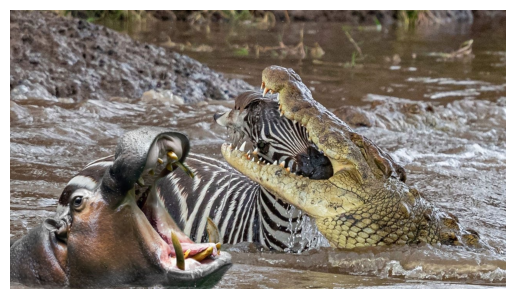

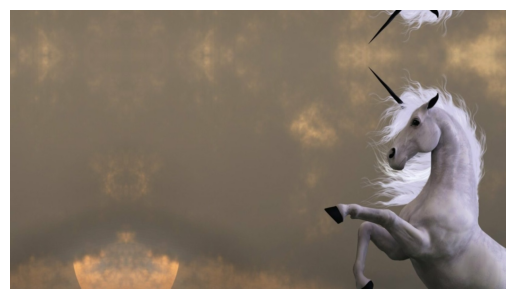

In [97]:
# Посмотрим, что это за похожие изображения
image1 = cv2.cvtColor(cv2.imread(test_path+'/000233.jpg'), cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(image1)
plt.axis("off")
plt.show()

image2 = cv2.cvtColor(cv2.imread(train_path+'/000008.jpg'), cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(image2)
plt.axis("off")
plt.show()


Алгоритм все еще часто ложно срабатывает, и одной геометрии не хватает

### 1.2. Дополняем SIFT предобработкой и агументациями

In [99]:
# Функция для применения CLAHE (увеличение контраста)
def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    processed_images = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe_img = clahe.apply(gray)
        processed_images.append(cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR))
    return processed_images

# Функция для изменения размера изображений
def resize_images(images, size=(512, 512)):
    resized_images = [cv2.resize(img, size) for img in images]
    return resized_images

# Функция для вычисления дескрипторов SIFT с настройками, чтобы избегать точек на фоне
def compute_sift_descriptors(images):
    sift = cv2.SIFT_create(nfeatures=1300, nOctaveLayers=4, contrastThreshold=0.03)
    descriptors_list = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        descriptors_list.append(descriptors)
    return descriptors_list

# Аугментации для тестовых изображений (добавлено вертикальное отражение)
def generate_augmented_versions(image):
    versions = []
    versions.append(image)  # оригинал
    versions.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))  # Поворот на 90 градусов по часовой стрелке
    versions.append(cv2.rotate(image, cv2.ROTATE_180))  # Поворот на 180 градусов
    versions.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))  # Поворот на 90 градусов против часовой стрелки
    versions.append(cv2.flip(image, 1))  # Горизонтальное отражение
    versions.append(cv2.flip(image, 0))  # Вертикальное отражение
    versions.append(cv2.bitwise_not(image))  # Инверсия цвета
    return versions

# Функция для поиска похожих изображений с использованием FLANN
def find_similar_images(test_images, test_filenames, train_images, train_filenames, threshold=90, ratio_test_threshold=0.85):
    # Подготовка FLANN для быстрого поиска
    index_params = dict(algorithm=1, trees=10)  # KDTree
    search_params = dict(checks=50)  
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    similar_images = {}

    # Вычисление дескрипторов для обучающих и тестовых изображений
    train_images = apply_clahe(train_images)
    test_images = apply_clahe(test_images)
    
    train_images_resized = resize_images(train_images)
    test_images_resized = resize_images(test_images)
    
    train_descriptors = compute_sift_descriptors(train_images_resized)
    test_descriptors = []
    
    # Генерация аугментированных версий тестовых изображений и их дескрипторов
    for test_img in test_images_resized:
        augmented_images = generate_augmented_versions(test_img)
        augmented_descriptors = compute_sift_descriptors(augmented_images)
        test_descriptors.append(augmented_descriptors)

    # Перебор всех тестовых изображений
    for i, test_desc_list in enumerate(test_descriptors):
        test_filename = test_filenames[i]
        best_match_filename = None
        best_match_score = 0
        best_match_details = None

        # Перебор аугментированных версий каждого тестового изображения
        for test_desc in test_desc_list:
            if test_desc is None:
                continue
            for j, train_desc in enumerate(train_descriptors):
                if train_desc is not None:
                    # Ищем совпадения через FLANN
                    matches = flann.knnMatch(test_desc, train_desc, k=2)

                    # Применяем Ratio Test
                    good_matches = []
                    for m, n in matches:
                        if m.distance < ratio_test_threshold * n.distance:
                            good_matches.append(m)

                    # Постобработка совпадений
                    if len(good_matches) > best_match_score and len(good_matches) >= threshold:
                        best_match_score = len(good_matches)
                        best_match_filename = train_filenames[j]
                        best_match_details = good_matches

        # Постобработка для нахождения наилучшего совпадения
        if best_match_filename:
            similar_images[test_filename] = {
                "match": best_match_filename,
                "score": best_match_score,
                "matches": best_match_details
            }

    return similar_images

In [101]:
# train_images_path = "/Users/alinamiller/Desktop/AI Talent Hub/CV/data/train_1"
# test_images_path = "/Users/alinamiller/Desktop/AI Talent Hub/CV/data/test_1"

# Загрузка изображений из папок
# train_filenames = [f for f in os.listdir(train_images_path) if f.endswith('.jpg') or f.endswith('.png')]
# test_filenames = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]

# train_images = [cv2.imread(os.path.join(train_images_path, filename)) for filename in train_filenames]
# test_images = [cv2.imread(os.path.join(test_images_path, filename)) for filename in test_filenames]

# Находим похожие изображения
similar_images = find_similar_images(test_images, test_filenames, train_images, train_filenames)

# Вывод результатов
for test_file, match_info in similar_images.items():
    print(f"Тестовое изображение {test_file} похоже на {match_info['match']}")
    print(f"Количество совпадений: {match_info['score']}")

Тестовое изображение 000233.jpg похоже на 000220.jpg
Количество совпадений: 146
Тестовое изображение 000221.jpg похоже на 000262.jpg
Количество совпадений: 245
Тестовое изображение 000252.jpg похоже на 000009.jpg
Количество совпадений: 181
Тестовое изображение 000309.jpg похоже на 000262.jpg
Количество совпадений: 131
Тестовое изображение 000266.jpg похоже на 000232.jpg
Количество совпадений: 574
Тестовое изображение 000313.jpg похоже на 000232.jpg
Количество совпадений: 486
Тестовое изображение 000275.jpg похоже на 000262.jpg
Количество совпадений: 233
Тестовое изображение 000329.jpg похоже на 000262.jpg
Количество совпадений: 98
Тестовое изображение 000238.jpg похоже на 000232.jpg
Количество совпадений: 383
Тестовое изображение 000015.jpg похоже на 000016.jpg
Количество совпадений: 618


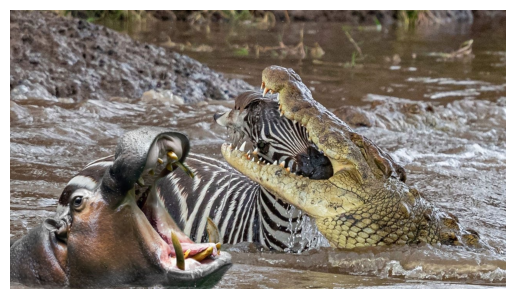

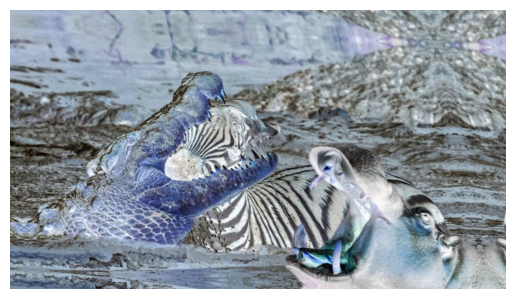

In [104]:
# Посмотрим, что это за похожие изображения
image1 = cv2.cvtColor(cv2.imread(test_path+'/000233.jpg'), cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(image1)
plt.axis("off")
plt.show()

image2 = cv2.cvtColor(cv2.imread(train_path+'/000220.jpg'), cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(image2)
plt.axis("off")
plt.show()


Как будто стало получше - действительно одно и то же изображение.
Проверим еще рандомную пару.

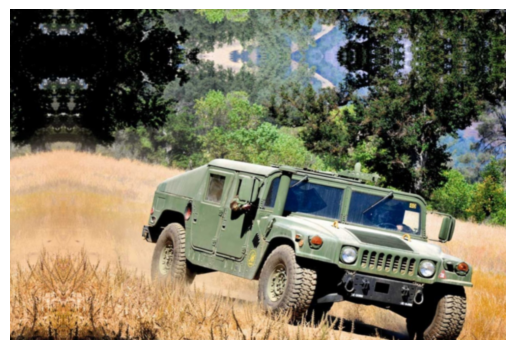

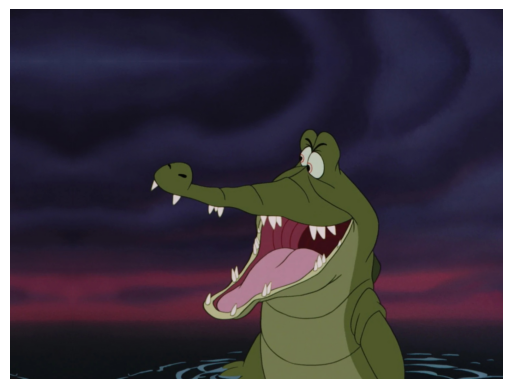

In [108]:
# Посмотрим, что это за похожие изображения
image1 = cv2.cvtColor(cv2.imread(test_path+'/000329.jpg'), cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(image1)
plt.axis("off")
plt.show()

image2 = cv2.cvtColor(cv2.imread(train_path+'/000262.jpg'), cv2.COLOR_BGR2RGB)

# Отображаем изображение
plt.imshow(image2)
plt.axis("off")
plt.show()


Тут совершенно разные изображения, работаем дальше

In [ ]:
# Сюда добавили flann и геометрии - RANSAC

# CLAHE для улучшения контраста
def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    processed_images = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe_img = clahe.apply(gray)
        processed_images.append(cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR))
    return processed_images

# Изменение размера
def resize_images(images, size=(512, 512)):
    return [cv2.resize(img, size) for img in images]

# Вычисление SIFT-дескрипторов
def compute_sift_descriptors(images):
    sift = cv2.SIFT_create(nfeatures=1300, nOctaveLayers=4, contrastThreshold=0.04, edgeThreshold=10)
    descriptor_data = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        descriptor_data.append((keypoints, descriptors))
    return descriptor_data

# Аугментации
def generate_augmented_versions(image):
    return [
        image,
        cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
        cv2.rotate(image, cv2.ROTATE_180),
        cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE),
        cv2.flip(image, 1),
        cv2.flip(image, 0),
        cv2.bitwise_not(image)
    ]

# Поиск похожих изображений
def find_similar_images(test_images, test_filenames, train_images, train_filenames,
                        threshold=120, ratio_test_threshold=0.88):
    
    index_params = dict(algorithm=1, trees=10)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    similar_images = {}

    # Предобработка
    train_images = resize_images(apply_clahe(train_images))
    test_images = resize_images(apply_clahe(test_images))

    train_data = compute_sift_descriptors(train_images)

    # Для каждого тестового изображения
    for i, test_img in enumerate(test_images):
        augmented_images = generate_augmented_versions(test_img)
        best_match = None
        best_inliers = 0

        for aug_img in augmented_images:
            test_kp, test_desc = compute_sift_descriptors([aug_img])[0]
            if test_desc is None:
                continue

            # Сравниваем с каждым train изображением
            for j, (train_kp, train_desc) in enumerate(train_data):
                if train_desc is None:
                    continue

                matches = flann.knnMatch(test_desc, train_desc, k=2)
                good_matches = [m for m, n in matches if m.distance < ratio_test_threshold * n.distance]

                if len(good_matches) >= threshold:
                    # Подготовка к RANSAC
                    src_pts = np.float32([test_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    dst_pts = np.float32([train_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                    try:
                        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                        inliers = int(mask.sum()) if mask is not None else 0
                    except:
                        inliers = 0

                    # Сохраняем лучшую пару
                    if inliers > best_inliers:
                        best_inliers = inliers
                        best_match = train_filenames[j]

        if best_match:
            similar_images[test_filenames[i]] = {
                "match": best_match,
                "inliers": best_inliers
            }

    return similar_images


In [ ]:
# Запуск нового варианта
train_images_path = "/Users/alinamiller/Desktop/AI Talent Hub/CV/data/train_1"
test_images_path = "/Users/alinamiller/Desktop/AI Talent Hub/CV/data/test_1"

# Загрузка изображений из папок
train_filenames = [f for f in os.listdir(train_images_path) if f.endswith('.jpg') or f.endswith('.png')]
test_filenames = [f for f in os.listdir(test_images_path) if f.endswith('.jpg') or f.endswith('.png')]

train_images = [cv2.imread(os.path.join(train_images_path, filename)) for filename in train_filenames]
test_images = [cv2.imread(os.path.join(test_images_path, filename)) for filename in test_filenames]

# Находим похожие изображения
similar_images = find_similar_images(test_images, test_filenames, train_images, train_filenames)


for test_file, match_info in similar_images.items():
    print(f"Тестовое изображение {test_file} похоже на {match_info['match']}")
    print(f"Количество совпадений: {match_info['inliers']}")


Все еще находятся изображения, которые совершенно не похожи, попробуем использовать персептивный хэш, будем также цчитывать цветовые гистограммы

### 1.3. Доработанный подход: SIFT+цветовые гистограммы+геометрия+ перцептивный хэш

Важно: тут я попыталась учесть, что в датасете есть фото, а есть мультяшние изображений и их надо уметь различать

In [114]:
pip install imagehash Pillow

Note: you may need to restart the kernel to use updated packages.


In [146]:
import imagehash
from PIL import Image
import numpy as np

# Функция для вычисления перцептивного хеша
def compute_phash(image):
    # Преобразуем OpenCV изображение в формат PIL
    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Вычисляем хеш
    hash_value = imagehash.phash(img_pil)
    return hash_value

# CLAHE для улучшения контраста
def apply_clahe(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    processed_images = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        clahe_img = clahe.apply(gray)
        processed_images.append(cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR))
    return processed_images

# Изменение размера изображений
def resize_images(images, size=(512, 512)):
    return [cv2.resize(img, size) for img in images]

# Вычисление цветовых гистограмм
def compute_color_histograms(images):
    histograms = []
    for img in images:
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist, 0, 1.0, cv2.NORM_MINMAX)
        histograms.append(hist)
    return histograms

# Вычисление SIFT-дескрипторов
def compute_sift_descriptors(images):
    sift = cv2.SIFT_create(nfeatures=1500, nOctaveLayers=4, contrastThreshold=0.04, edgeThreshold=10)
    descriptor_data = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        descriptor_data.append((keypoints, descriptors))
    return descriptor_data

# Аугментации изображений
def generate_augmented_versions(image):
    # Основные аугментации
    augmented = [image]
    
    # Добавляем повороты только для изображений достаточного размера
    if image.shape[0] > 100 and image.shape[1] > 100:
        augmented.extend([
            cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
            cv2.rotate(image, cv2.ROTATE_180),
            cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
        ])
    
    # Добавляем отражения
    augmented.extend([
        cv2.flip(image, 1),  # Горизонтальное отражение
        cv2.flip(image, 0)   # Вертикальное отражение
    ])
    
    return augmented

# Определяем тип изображения (мультипликационное, фотография и т.д.)
def classify_image_type(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_ratio = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
    
    # Анализ цветовой палитры
    unique_colors = np.unique(image.reshape(-1, 3), axis=0).shape[0]
    color_richness = unique_colors / (image.shape[0] * image.shape[1])
    
    if edge_ratio < 0.05 and color_richness < 0.1:
        return "simple"  # Простые изображения с небольшим количеством цветов
    elif edge_ratio > 0.15:
        return "detailed"  # Детализированные изображения
    else:
        return "cartoon"  # Мультипликационные изображения

# Поиск похожих изображений с адаптивными порогами
def find_similar_images(test_images, test_filenames, train_images, train_filenames):
    similar_images = {}
    
    # Задаем разные пороги для разных типов изображений
    thresholds = {
        "simple": {"hist": 0.7, "ratio": 0.6, "matches": 40, "inliers": 10, "phash": 8},
        "cartoon": {"hist": 0.6, "ratio": 0.6, "matches": 60, "inliers": 15, "phash": 12},
        "detailed": {"hist": 0.5, "ratio": 0.6, "matches": 80, "inliers": 20, "phash": 15}
    }
    
    # Предварительная обработка изображений
    train_images_resized = resize_images(train_images)
    test_images_resized = resize_images(test_images)
    
    # Вычисление хешей
    train_hashes = [compute_phash(img) for img in train_images_resized]
    
    # Вычисление гистограмм
    train_hists = compute_color_histograms(train_images_resized)
    
    # Вычисление SIFT-дескрипторов
    train_data = compute_sift_descriptors(train_images_resized)
    
    # Инициализация FLANN-матчера
    index_params = dict(algorithm=1, trees=10)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Для каждого тестового изображения
    for i, test_img in enumerate(test_images_resized):
        
        # Определяем тип изображения для адаптивных порогов
        img_type = classify_image_type(test_img)
        current_thresholds = thresholds[img_type]
        
        # Вычисляем хеш тестового изображения
        test_hash = compute_phash(test_img)
        
        # Вычисляем гистограмму тестового изображения
        test_hist = compute_color_histograms([test_img])[0]
        
        # Лучшее совпадение
        best_match = None
        best_score = 0
        best_details = {}
        
        # Сначала быстрая фильтрация по хешам
        potential_matches = []
        for j, train_hash in enumerate(train_hashes):
            hash_diffs = [(j, test_hash - h) for j, h in enumerate(train_hashes)]
            hash_diffs.sort(key=lambda x: x[1])
            potential_matches = [j for j, d in hash_diffs[:10] if d <= current_thresholds["phash"] + 5]
                    
        if not potential_matches:
            continue
        
        # Проверяем только потенциальные совпадения
        for j in potential_matches:
            # Сравниваем гистограммы
            hist_sim = cv2.compareHist(test_hist, train_hists[j], cv2.HISTCMP_CORREL)
            if hist_sim < current_thresholds["hist"]:
                continue
            
            # Если гистограммы достаточно похожи, переходим к SIFT
            augmented_images = generate_augmented_versions(test_img)
            
            for aug_img in augmented_images:
                test_kp, test_desc = compute_sift_descriptors([aug_img])[0]
                train_kp, train_desc = train_data[j]
                
                if test_desc is None or train_desc is None:
                    continue
                    
                if test_desc.shape[0] < 10 or train_desc.shape[0] < 10:
                    continue
                
                # Находим соответствия между дескрипторами
                matches = flann.knnMatch(test_desc, train_desc, k=2)
                
                # Применяем ratio test
                good_matches = []
                for m, n in matches:
                    if m.distance < current_thresholds["ratio"] * n.distance:
                        good_matches.append(m)
                
                if len(good_matches) < current_thresholds["matches"]:
                    continue
                    
                # RANSAC для нахождения геометрического преобразования
                try:
                    src_pts = np.float32([test_kp[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    dst_pts = np.float32([train_kp[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                    
                    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                    inliers = int(mask.sum()) if mask is not None else 0
                    
                    if inliers < current_thresholds["inliers"]:
                        continue
                        
                    # Вычисляем общий балл сходства
                    inlier_ratio = inliers / len(good_matches) if good_matches else 0
                    match_quality = len(good_matches) / min(len(test_desc), len(train_desc))
                    
                    # Обновленная формула без hash_distance
                    similarity_score = 0.5 * hist_sim + 0.5 * inlier_ratio
                    
                    if similarity_score > best_score:
                        best_score = similarity_score
                        best_match = train_filenames[j]
                        best_details = {
                            "similarity_score": similarity_score,
                            "hist_similarity": hist_sim,
                            "inliers": inliers,
                            "good_matches": len(good_matches),
                            "match_quality": match_quality
                        }
                except:
                    continue
        
        # Если найдено хорошее совпадение
        if best_match and best_score > 0.6:  # Минимальный порог общего сходства
            similar_images[test_filenames[i]] = {
                "match": best_match,
                "score": best_score,
                "details": best_details
            }
    
    return similar_images

# Функция для демонстрации найденных соответствий
def visualize_matches(test_img, train_img, test_name, train_name, output_dir="matches"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Изменяем размер изображений для визуализации
    h = 300
    test_img_resized = cv2.resize(test_img, (int(test_img.shape[1] * h / test_img.shape[0]), h))
    train_img_resized = cv2.resize(train_img, (int(train_img.shape[1] * h / train_img.shape[0]), h))
    
    # Создаем визуализацию сопоставления
    vis = np.hstack([test_img_resized, train_img_resized])
    
    # Добавляем текст с именами файлов
    cv2.putText(vis, f"Test: {test_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(vis, f"Match: {train_name}", (test_img_resized.shape[1] + 10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) 
    
    # Сохраняем результат
    output_path = os.path.join(output_dir, f"{os.path.splitext(test_name)[0]}_matches.jpg")
    cv2.imwrite(output_path, vis)
    
    return output_path

# Основная функция
def find_duplicates(train_path, test_path, output_dir="matches"):
    # Загрузка изображений из папок
    train_filenames = [f for f in os.listdir(train_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    test_filenames = [f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    train_images = []
    for filename in train_filenames:
        img = cv2.imread(os.path.join(train_path, filename))
        if img is not None:
            train_images.append(img)
        else:
            print(f"Ошибка при загрузке {filename}")
            train_filenames.remove(filename)

    test_images = []
    for filename in test_filenames:
        img = cv2.imread(os.path.join(test_path, filename))
        if img is not None:
            test_images.append(img)
        else:
            print(f"Ошибка при загрузке {filename}")
            test_filenames.remove(filename)

    # Находим похожие изображения
    similar_images = find_similar_images(test_images, test_filenames, train_images, train_filenames)

    # Получаем упорядоченный список файлов с дубликатами
    duplicate_filenames = sorted(similar_images.keys())

    print("\nНайденные дубликаты (упорядоченный список):")
    for filename in duplicate_filenames:
        print(filename)
    
    return similar_images


In [148]:
# Сразу зададим функцию расчета F1 меры

def calculate_f1(ground_truth, detected):
    ground_truth_set = set(ground_truth)
    detected_set = set(detected)

    tp = len(ground_truth_set & detected_set)
    fp = len(detected_set - ground_truth_set)
    fn = len(ground_truth_set - detected_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }


In [160]:
# Сгрузим ground_truth и проверим все сразу на публичном датасете
train_path = "/Users/alinamiller/Desktop/public_data/train"
test_path = "/Users/alinamiller/Desktop/public_data/test"
truth_path = "/Users/alinamiller/Desktop/public_data/leakage_files.txt"

with open(truth_path, 'r', encoding='utf-8') as file:
            filenames = [line.strip() for line in file if line.strip()]
    
ground_truth = filenames
detected = find_duplicates(train_path, test_path)

result = calculate_f1(ground_truth, detected)
for k, v in result.items():
    print(f"{k}: {v}")


Найденные дубликаты (упорядоченный список):
000017.jpg
000033.jpg
000060.jpg
000089.jpg
000126.jpg
000138.jpg
000144.jpg
000155.jpg
000168.jpg
000184.jpg
000201.jpg
000219.jpg
000235.jpg
000236.jpg
000247.jpg
000250.jpg
000278.jpg
000289.jpg
000307.jpg
000311.jpg
000338.jpg
000374.jpg
000409.jpg
000415.jpg
000424.jpg
000465.jpg
000481.jpg
000510.jpg
000515.jpg
000525.jpg
000570.jpg
000571.jpg
000574.jpg
000581.jpg
TP: 34
FP: 0
FN: 25
Precision: 1.0
Recall: 0.576271186440678
F1: 0.7311827956989247


F1 мера стала на довольно высоком уровне, но все равно часть изображений теряется

### 1.4. Группировка изображений классическим алгоритмом

In [3]:
# тут лежат корректные группы
group_path = "/Users/alinamiller/Desktop/public_data/groups.txt"

Разложим изображения из папки train+test по группам

In [164]:
from sklearn.cluster import DBSCAN
from collections import defaultdict

def load_images_from_folder(folder):
    images = {}
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        img = cv2.imread(path)
        if img is not None:
            images[fname] = img
    return images

def extract_features(images):
    orb = cv2.ORB_create()
    features = {}
    for name, img in images.items():
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = orb.detectAndCompute(gray, None)
        features[name] = descriptors
    return features

def compute_similarity_matrix(features):
    names = list(features.keys())
    sim_matrix = np.zeros((len(names), len(names)))

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            des1 = features[names[i]]
            des2 = features[names[j]]
            if des1 is not None and des2 is not None:
                matches = bf.match(des1, des2)
                score = -np.mean([m.distance for m in matches]) if matches else 0
                sim_matrix[i, j] = sim_matrix[j, i] = score
    return sim_matrix, names

def cluster_images(sim_matrix, names, eps=30, min_samples=2):
    db = DBSCAN(metric='precomputed', eps=eps, min_samples=min_samples)
    dist_matrix = -sim_matrix  
    labels = db.fit_predict(dist_matrix)
    clusters = defaultdict(list)

    for name, label in zip(names, labels):
        if label != -1:
            clusters[label].append(name)

    # Фильтруем группы, где меньше 3 изображений
    valid_clusters = [group for group in clusters.values() if len(group) > 2]
    return valid_clusters

def read_ground_truth(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
    gt_clusters = [set(line.strip().split()) for line in lines if line.strip()]
    return gt_clusters

def calculate_f1(true_labels, predicted_labels):
    tp = len(true_labels & predicted_labels)
    fp = len(predicted_labels - true_labels)
    fn = len(true_labels - predicted_labels)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1

def evaluate_groups_accuracy(pred_clusters, gt_clusters):
    gt_sets = [set(g) for g in gt_clusters]
    pred_sets = [set(p) for p in pred_clusters]

    matched = 0
    results_per_group = []

    # Перебираем все группы из ground truth
    for gt in gt_sets:
        group_results = []
        best_match = None
        max_correct = 0

        for pred in pred_sets:
            # Считаем количество совпадений
            correct = len(pred & gt)
            
            # Если найдено больше совпадений, обновляем лучшую группу
            if correct > max_correct:
                max_correct = correct
                best_match = pred
        
        if best_match:
            # Рассчитываем долю верно угаданных изображений
            accuracy = (max_correct / len(gt)) * 100

            # Рассчитываем F1-меру
            f1 = calculate_f1(gt, best_match)

            results_per_group.append({
                "Ground Truth Group": gt,
                "Predicted Group": best_match,
                "Accuracy": accuracy,
                "F1": f1
            })
            matched += 1

    overall_accuracy = matched / len(gt_sets) if gt_sets else 0

    return {
        "Correct Groups": matched,
        "Total GT Groups": len(gt_sets),
        "Overall Accuracy": overall_accuracy,
        "Group Results": results_per_group,
        "Predicted Groups": pred_clusters,
        "Ground Truth Groups": gt_clusters
    }

In [166]:
# Датафрейм с информацией о том, какому кол-ву изображений мы назвачили группу и какую
def build_image_group_dataframe(all_image_names, pred_clusters):
    image_to_group = {}
    for cluster_idx, group in enumerate(pred_clusters):
        for image_name in group:
            image_to_group[image_name] = cluster_idx + 1  # +1 для удобства чтения

    data = []
    for image_name in sorted(all_image_names):
        group_id = image_to_group.get(image_name)
        in_group = group_id is not None
        data.append({
            "Image": image_name,
            "Group ID": group_id if in_group else "None",
            "In Group": in_group
        })

    df = pd.DataFrame(data)
    return df

In [13]:
# train_path = "/Users/alinamiller/Desktop/public_data/train"
# test_path = "/Users/alinamiller/Desktop/public_data/test"
ground_truth_path = "/Users/alinamiller/Desktop/public_data/groups.txt"
# ground_truth_groups = "/Users/alinamiller/Desktop/public_data/groups.txt"

In [174]:
all_images = {}
all_images.update(load_images_from_folder(train_path))
all_images.update(load_images_from_folder(test_path))

features = extract_features(all_images)
sim_matrix, names = compute_similarity_matrix(features)
pred_clusters = cluster_images(sim_matrix, names)

In [175]:
gt_clusters = read_ground_truth(ground_truth_path)
results = evaluate_groups_accuracy(pred_clusters, gt_clusters)
    
print("Overall Accuracy:", results["Overall Accuracy"])
print("\nPredicted Groups:")
for i, group in enumerate(results["Predicted Groups"]):
    print(f"Group {i+1}: {group}")
    
print("\nGround Truth Groups:")
for i, group in enumerate(results["Ground Truth Groups"]):
    print(f"Group {i+1}: {group}")


Overall Accuracy: 0.0

Predicted Groups:
Group 1: ['000191.jpg', '000582.jpg', '000141.jpg', '000082.jpg', '000416.jpg']
Group 2: ['000350.jpg', '000436.jpg', '000147.jpg', '000357.jpg', '000123.jpg', '000450.jpg', '000077.jpg']
Group 3: ['000387.jpg', '000030.jpg', '000131.jpg', '000067.jpg', '000316.jpg', '000525.jpg']
Group 4: ['000542.jpg', '000183.jpg', '000156.jpg', '000502.jpg', '000161.jpg', '000570.jpg']
Group 5: ['000556.jpg', '000119.jpg', '000040.jpg']
Group 6: ['000026.jpg', '000380.jpg', '000133.jpg', '000242.jpg']
Group 7: ['000580.jpg', '000408.jpg', '000333.jpg', '000480.jpg', '000457.jpg', '000325.jpg', '000048.jpg', '000172.jpg', '000360.jpg']
Group 8: ['000225.jpg', '000020.jpg', '000276.jpg', '000033.jpg']
Group 9: ['000379.jpg', '000433.jpg', '000036.jpg', '000104.jpg', '000448.jpg']
Group 10: ['000435.jpg', '000031.jpg', '000180.jpg', '000546.jpg', '000053.jpg', '000137.jpg', '000254.jpg', '000054.jpg', '000261.jpg', '000458.jpg', '000417.jpg', '000012.jpg', '000

Групп меншьше, чем в реальности, но некоторые файлы пересекаются

In [182]:
# Посмотрим, какое кол-во изображений вообще размечено группами
import pandas as pd
df = build_image_group_dataframe(all_images, pred_clusters)
print(df)


          Image Group ID  In Group
0    000000.jpg       36      True
1    000001.jpg       11      True
2    000002.jpg     None     False
3    000003.jpg     None     False
4    000004.jpg       22      True
..          ...      ...       ...
587  000587.jpg     None     False
588  000588.jpg     None     False
589  000589.jpg       36      True
590  000590.jpg       11      True
591  000591.jpg     None     False

[592 rows x 3 columns]


## 2. ResNet для поиска похожих изображений

In [184]:
from torchvision.models import resnet50
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Загружаем предобученную модель ResNet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # удаляем классификатор
model.eval().to(device)

# Преобразование для входа в модель
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Вычисление эмбеддинга
def extract_embedding(image):
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image).squeeze().cpu().numpy()
    return embedding

# Поиск похожих изображений
def find_similar_images_resnet(test_images, test_filenames, train_images, train_filenames, threshold=0.95):
    similar_images = {}
    
    print("Извлечение эмбеддингов train изображений...")
    train_embeddings = [extract_embedding(img) for img in tqdm(train_images)]
    
    print("Извлечение эмбеддингов test изображений...")
    test_embeddings = [extract_embedding(img) for img in tqdm(test_images)]

    print("Сравнение эмбеддингов...")
    for i, (test_emb, test_name) in enumerate(zip(test_embeddings, test_filenames)):
        similarities = cosine_similarity([test_emb], train_embeddings)[0]
        best_idx = np.argmax(similarities)
        best_score = similarities[best_idx]
        if best_score > threshold:
            similar_images[test_name] = {
                "match": train_filenames[best_idx],
                "score": best_score
            }

    return similar_images


/Users/alinamiller/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alinamiller/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/alinamiller/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|███████████████████████████████████████| 97.8M/97.8M [02:21<00:00, 725kB/s]


In [186]:
def load_images_from_folder(folder):
    filenames = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    images = []
    for filename in filenames:
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        else:
            filenames.remove(filename)
    return images, filenames

def find_duplicates_resnet(train_path, test_path):
    train_images, train_filenames = load_images_from_folder(train_path)
    test_images, test_filenames = load_images_from_folder(test_path)
    return find_similar_images_resnet(test_images, test_filenames, train_images, train_filenames)

def calculate_f1(ground_truth, detected):
    detected_set = set(detected.keys())
    ground_truth_set = set(ground_truth)

    tp = len(ground_truth_set & detected_set)
    fp = len(detected_set - ground_truth_set)
    fn = len(ground_truth_set - detected_set)

    precision = tp / (tp + fp) if tp + fp > 0 else 0.0
    recall = tp / (tp + fn) if tp + fn > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0.0

    return {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [3]:
# Использование
train_path = "/Users/alinamiller/Desktop/public_data/train"
test_path = "/Users/alinamiller/Desktop/public_data/test"
truth_path = "/Users/alinamiller/Desktop/public_data/leakage_files.txt"

In [190]:
with open(truth_path, 'r', encoding='utf-8') as f:
    ground_truth = [line.strip() for line in f if line.strip()]

detected = find_duplicates_resnet(train_path, test_path)
result = calculate_f1(ground_truth, detected)

for k, v in result.items():
    print(f"{k}: {v:.4f}")


Извлечение эмбеддингов train изображений...


100%|█████████████████████████████████████████| 456/456 [00:53<00:00,  8.55it/s]


Извлечение эмбеддингов test изображений...


100%|█████████████████████████████████████████| 136/136 [00:20<00:00,  6.58it/s]


Сравнение эмбеддингов...
TP: 41.0000
FP: 0.0000
FN: 18.0000
Precision: 1.0000
Recall: 0.6949
F1: 0.8200


F1 больше 0.8 - нас это устраивает.
Перейдем к сбору групп.

## Сбор групп ResNet-ом

In [86]:
train_path = "C:/Users/millerai/Desktop/public_data/train"
test_path = "C:/Users/millerai/Desktop/public_data/test"
truth_path = "C:/Users/millerai/Desktop/public_data/leakage_files.txt"
ground_truth_path = "C:/Users/millerai/Desktop/public_data/groups.txt"

In [71]:
import gc
from torchvision import models, transforms
# from sklearn.metrics.pairwise import cosine_similarity


def list_image_paths(folder):
    return {fname: os.path.join(folder, fname) for fname in os.listdir(folder)
            if fname.lower().endswith(('.jpg', '.png', '.jpeg'))}

In [ ]:
# Собираем фичи
def extract_features_resnet(image_paths):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    base_model = models.resnet50(pretrained=True)
    model = torch.nn.Sequential(*list(base_model.children())[:-1])  # убираем классификатор
    model.eval().to(device)

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    features = {}
    with torch.no_grad():
        for name, path in tqdm(image_paths.items(), desc="Extracting features (ResNet50)"):
            try:
                img = cv2.imread(path)
                if img is None:
                    print(f"Could not load image: {path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                input_tensor = preprocess(img).unsqueeze(0).to(device)

                output = model(input_tensor).squeeze().cpu().numpy()
                output /= np.linalg.norm(output)  # нормализация для cosine similarity
                features[name] = output

                del input_tensor, output, img
                gc.collect()

            except Exception as e:
                print(f"Error processing {name}: {e}")

    return features

In [ ]:
# Собираем группы
from collections import deque

def build_groups(features, threshold=0.95):
    names = list(features.keys())
    vectors = np.array([features[name] for name in names])

    similarity_matrix = cosine_similarity(vectors)
    n = len(names)
    visited = set()
    groups = []

    for idx in range(n):
        if names[idx] in visited:
            continue

        group = []
        queue = deque()
        queue.append(idx)
        visited.add(names[idx])

        while queue:
            current_idx = queue.popleft()
            group.append(names[current_idx])

            for neighbor_idx in range(n):
                if neighbor_idx != current_idx and similarity_matrix[current_idx, neighbor_idx] >= threshold:
                    if names[neighbor_idx] not in visited:
                        visited.add(names[neighbor_idx])
                        queue.append(neighbor_idx)

        if len(group) > 1:
            groups.append(group)

    return groups

In [ ]:
# Функция сборки всего
def main(train_folder, test_folder, threshold=0.95):
    print("Loading images...")
    all_paths = {}
    all_paths.update(list_image_paths(train_folder))
    all_paths.update(list_image_paths(test_folder))

    print("Extracting features...")
    features = extract_features_resnet(all_paths)

    print("Building groups...")
    groups = build_groups(features, threshold=threshold)

    print(f"\nTotal groups found: {len(groups)}")
    for i, group in enumerate(groups):
        print(f"\nGroup {i+1}:")
        for img_name in group:
            print(f"  {img_name}")

    return groups

In [72]:
# Проверка работы
train_folder = "path/to/train"
test_folder = "path/to/test"
groups = main(train_path, test_path, threshold=0.95)

Loading images...
Extracting features...


C:\Users\millerai\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\millerai\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features (ResNet50): 100%|████████████████████████████████████████████████| 592/592 [03:09<00:00,  3.12it/s]


Building groups...

Total groups found: 75

Group 1:
  000001.jpg
  000051.jpg
  000229.jpg
  000281.jpg
  000353.jpg
  000428.jpg
  000590.jpg
  000536.jpg
  000560.jpg
  000130.jpg
  000248.jpg
  000144.jpg
  000212.jpg
  000296.jpg
  000427.jpg
  000043.jpg
  000571.jpg
  000322.jpg
  000114.jpg
  000564.jpg
  000414.jpg

Group 2:
  000002.jpg
  000175.jpg
  000259.jpg
  000438.jpg

Group 3:
  000004.jpg
  000117.jpg
  000125.jpg
  000264.jpg
  000403.jpg
  000429.jpg
  000444.jpg
  000459.jpg
  000138.jpg
  000235.jpg
  000250.jpg
  000034.jpg
  000263.jpg
  000354.jpg
  000476.jpg
  000005.jpg
  000534.jpg
  000384.jpg
  000503.jpg

Group 4:
  000006.jpg
  000066.jpg
  000171.jpg
  000211.jpg
  000233.jpg
  000237.jpg
  000260.jpg
  000330.jpg
  000397.jpg
  000445.jpg
  000484.jpg
  000491.jpg
  000554.jpg
  000586.jpg
  000251.jpg
  000510.jpg
  000446.jpg
  000562.jpg

Group 5:
  000010.jpg
  000238.jpg
  000168.jpg
  000097.jpg
  000479.jpg
  000047.jpg
  000182.jpg
  000310.j

Стало сильно лучше объединяться в группы, но все еще групп слишком много, поменяем threshold.
Также добавим функцию для сборки датафрейма с группами предсказанными и реальными.

In [ ]:
# Собираем предсказанные группы
def build_predicted_groups(features, threshold=0.95):
    names = list(features.keys())
    vectors = np.array([features[name] for name in names])

    similarity_matrix = cosine_similarity(vectors)
    n = len(names)
    visited = set()
    groups = []

    for idx in range(n):
        if names[idx] in visited:
            continue

        group = []
        queue = deque()
        queue.append(idx)
        visited.add(names[idx])

        while queue:
            current_idx = queue.popleft()
            group.append(names[current_idx])

            for neighbor_idx in range(n):
                if neighbor_idx != current_idx and similarity_matrix[current_idx, neighbor_idx] >= threshold:
                    if names[neighbor_idx] not in visited:
                        visited.add(names[neighbor_idx])
                        queue.append(neighbor_idx)

        if group:  # Добавляем даже маленькие группы
            groups.append(group)

    return groups

In [ ]:
# Загружает реальные группы
def parse_ground_truth(filepath):
    groups = []
    with open(filepath, 'r') as f:
        for line in f:
            filenames = [fname.strip() for fname in line.strip().split(',') if fname.strip()]
            if filenames:
                groups.append(filenames)
    return groups

In [161]:
# Собираем датафрейм
def build_comparison_dataframe(predicted_groups, ground_truth_groups):
    pred_label_map = {}
    for idx, group in enumerate(predicted_groups):
        for fname in group:
            pred_label_map[fname] = idx

    gt_label_map = {}
    for idx, group in enumerate(ground_truth_groups):
        for fname in group:
            gt_label_map[fname] = idx

    all_filenames = set(pred_label_map.keys()) | set(gt_label_map.keys())

    data = []
    for fname in all_filenames:
        data.append({
            'filename': fname,
            'predicted_group': pred_label_map.get(fname, -1),
            'ground_truth_group': gt_label_map.get(fname, -1)
        })

    df = pd.DataFrame(data)
    return df

In [162]:
# Все пути к изображениям
all_paths = {}
all_paths.update(list_image_paths(train_path))
all_paths.update(list_image_paths(test_path))

In [163]:
features = extract_features_resnet(all_paths)

Extracting features (ResNet50): 100%|████████████████████████████████████████████████| 592/592 [04:01<00:00,  2.45it/s]


In [167]:
# Собираем группы
predicted_groups = build_predicted_groups(features, threshold=0.85)

ground_truth_groups = parse_ground_truth(ground_truth_path)


In [168]:
# Собираем датайрем
df = build_comparison_dataframe(predicted_groups, ground_truth_groups)
df.tail(30)

filename  predicted_group  ground_truth_group
562  000395.jpg               37                   4
563  000136.jpg                1                   0
564  000128.jpg               22                   4
565  000456.jpg               33                  37
566  000478.jpg                3                  13
567  000055.jpg                3                  42
568  000465.jpg               30                  37
569  000355.jpg               48                  28
570  000294.jpg               34                   2
571  000088.jpg                3                  23
572  000450.jpg               23                  21
573  000381.jpg                3                  42
574  000565.jpg               70                  33
575  000403.jpg                3                  27
576  000160.jpg               68                  20
577  000306.jpg                5                  45
578  000228.jpg               20                  39
579  000204.jpg                6                  10
580  000049.jpg               71                   8
581  000206.jpg                6                  10
582  000430.jpg               70                  33
583  000502.jpg                3                  16
584  000184.jpg                3                  16
585  000562.jpg                4                  11
586  000343.jpg                6                  10
587  000512.jpg                5                  45
588  000283.jpg                2                  12
589  000027.jpg                3                  42
590  000201.jpg                3                  13
591  000075.jpg               21                  44

In [169]:
# Выгрузим группы для сравнения
df.to_csv('df.csv')

#### Маппинг предсказанных групп на реальные

In [170]:
from collections import Counter

def map_predicted_to_gt(df):
    overlap = {}

    for pred_grp in df['predicted_group'].unique():
        candidates = df[df['predicted_group'] == pred_grp]
        gt_counts = Counter(candidates['ground_truth_group'])
        gt_counts.pop(-1, None)  # Убираем -1, если были отсутствующие ground_truth
        if gt_counts:
            best_match_gt = gt_counts.most_common(1)[0][0]
            overlap[pred_grp] = best_match_gt

    # Теперь пересопоставим predicted_group в датафрейме
    df['mapped_predicted_group'] = df['predicted_group'].map(overlap).fillna(-1).astype(int)
    return df


In [171]:
df = map_predicted_to_gt(df)
print(df)

       filename  predicted_group  ground_truth_group  mapped_predicted_group
0    000552.jpg                8                  30                      30
1    000290.jpg               21                  44                      44
2    000121.jpg                3                  42                      42
3    000319.jpg               45                  23                      23
4    000231.jpg                3                  42                      42
..          ...              ...                 ...                     ...
587  000512.jpg                5                  45                      45
588  000283.jpg                2                  12                      12
589  000027.jpg                3                  42                      42
590  000201.jpg                3                  13                      42
591  000075.jpg               21                  44                      44

[592 rows x 4 columns]


In [173]:
df.to_csv('mapped_groups.csv')